# Tutorial 10.1: Autoregressive Image Modeling

In this tutorial, we implement an autoregressive likelihood model for the task of image modeling. 
Autoregressive models are naturally strong generative models that constitute the current state-of-the-art on likelihood-based image modeling. 
However, disadvantages of these models include slow sampling and the lack of a latent space.
We will explore and discuss these benefits and drawbacks along our implementation.

Our implementation will focus on the PixelCNN [2] model. Most current SOTA models use PixelCNN as their fundamental architecture, and various additions have been proposed to improve the performance. Hence, implementing PixelCNN is a good starting point for our short tutorial. 

First of all, we need to import our standard libraries:

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


We will again work on the MNIST dataset and use 8-bits per pixel (values between 0 and 255). The dataset is loaded below:

In [2]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

def discretize(sample):
    return (sample * 255).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
set_seed(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=0)

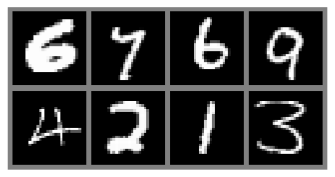

In [3]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

## Masked autoregressive convolutions

The core module of PixelCNN is its masked convolutions. 
During training, we use a training image as input to the model and obtain as output the prediction for each pixel based on its predecessors.
Thereby, we need to ensure that the prediction for a specific pixel can only be influenced by its predecessors and not by its own value or any "future" pixels.
For this, we apply convolutions with a mask. 
Specifically, we want to set those entries of the weight matrix to zero that take pixels on the right and below into account.
First, let's implement a module that allows us to apply an arbitrary mask to a convolution:

In [4]:
class MaskedConvolution(nn.Module):
    
    def __init__(self, c_in, c_out, mask, **kwargs):
        super().__init__()
        self.register_buffer('mask', mask[None,None])
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)
        
    def forward(self, x):
        self.conv.weight.data *= self.mask
        return self.conv(x)

In the original PixelCNN paper [1], the convolutions were masked by removing the weights for the pixels on the right and all below the center.
However, this lead to a "blind spot" of pixels on the far right that can not be taken into account for the prediction of a pixel.
Thus, van den Oord et. al [2] proposed to split the convolutions into a vertical and a horizontal stack, where the vertical looks at all pixels above the current one, and the horizontal at all on the left.

We implement them here as follows:

In [5]:
class VerticalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0
        if mask_center:
            mask[kernel_size//2,:] = 0
        super().__init__(c_in, c_out, mask, **kwargs)
        
class HorizontalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0
        if mask_center:
            mask[0,kernel_size//2] = 0
        super().__init__(c_in, c_out, mask, **kwargs)

Note that for the very first convolution we apply, we need to mask the center pixel as well.

### Visualizing the receptive field

To validate our implementation of masked convolutions, we can visualize the receptive field we obtain with such convolutions. 
The receptive field can be empirically measured by backpropagating the error of a single pixel with respect to the input:

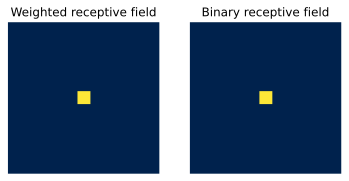

In [6]:
inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

def show_center_recep_field(img, out):
    loss = out[0,:,img.shape[2]//2,img.shape[3]//2].sum() # L1 loss for simplicity
    loss.backward(retain_graph=True) # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    img_grads = img.grad.abs()
    img.grad.fill_(0)
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0]) 
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

show_center_recep_field(inp_img, inp_img)

Let's first visualize the receptive field of a horizontal convolution without the center pixel:

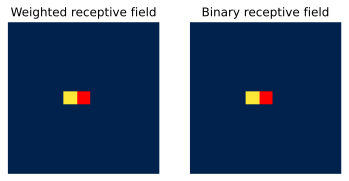

In [7]:
horiz_conv = HorizontalStackConvolution(1, 1, mask_center=True)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
horiz_img = horiz_conv(inp_img)
show_center_recep_field(inp_img, horiz_img)

As expected, the receptive field is only the pixel on the left. If we use a larger kernel size, more pixels would be taken into account on the left.

Next, let's look at the vertical convolution:

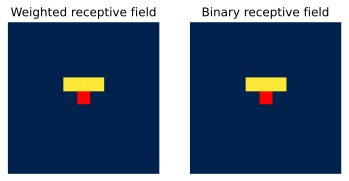

In [8]:
vert_conv = VerticalStackConvolution(1, 1, mask_center=True)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)
vert_img = vert_conv(inp_img)
show_center_recep_field(inp_img, vert_img)

The vertical convolution takes all pixels above into account. Combining these two, we get the L-shaped receptive field:

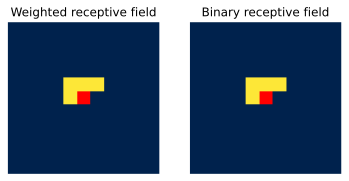

In [9]:
horiz_img = vert_img + horiz_img
show_center_recep_field(inp_img, horiz_img)

When we stack multiple horizontal and vertical convolutions, we need to take two aspects into account:

(1) The center should not be masked anymore for the following convolutions as the features at the pixel's position are already independent of its actual value (If it is hard to imagine why we can do this, just change the value below to `mask_center=True` and see what happens).

(2) The vertical convolution is not allowed to work on features from the horizontal convolution. In the feature map of the horizontal convs, a pixel contains information about all of the "true" pixels on the left. If we apply a vertical convolution which also uses features from the right, we effectively expand our receptive field to the true input which we want to prevent. Thus, the feature maps can only be merged for the horizontal convolution.

Using this, we can stack the convolutions in the following way:

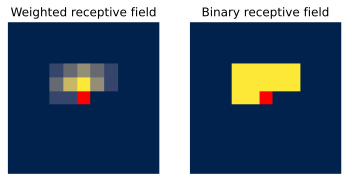

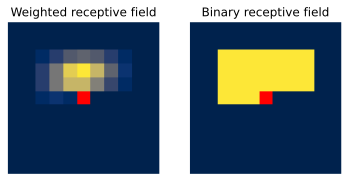

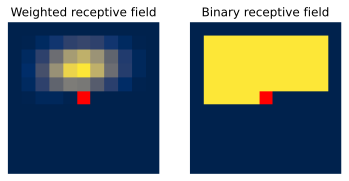

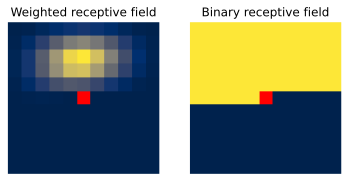

In [10]:
horiz_conv = HorizontalStackConvolution(1, 1, mask_center=False)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
vert_conv = VerticalStackConvolution(1, 1, mask_center=False)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)

for _ in range(4):
    vert_img = vert_conv(vert_img)
    horiz_img = horiz_conv(horiz_img) + vert_img
    show_center_recep_field(inp_img, horiz_img)

Thereby, the receptive field for the vertical stack looks as follows:

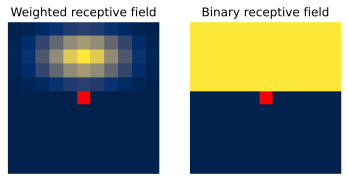

In [11]:
show_center_recep_field(inp_img, vert_img)

Hence, we can validate that our implementation works as we initially expected/hoped it to.
As a final step, let's clean up the computation graph we still had kept in memory for the visualization of the receptive field:

In [12]:
del inp_img, horiz_conv, vert_conv

## PixelCNN

### Gated Convolutions

For visualizing the receptive field, we assumed a very simplified stack of vertical and horizontal convolutions. 
Obviously, there are more sophisticated ways of doing it, and PixelCNN uses gated convolutions for this.
Specifically, the Gated Convolution block in PixelCNN looks as follows:

<img src="PixelCNN_GatedConv.svg" width=600 style="float:left"/>

The left path is the vertical stack (NxN convolution is masked correspondingly), and the right path is the horizontal stack. 
The implementation in PyTorch is fairly straight forward for this block:

In [13]:
class GatedMaskedConv(nn.Module):
    
    def __init__(self, c_in, **kwargs):
        super().__init__()
        self.conv_vert = VerticalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*c_in, 2*c_in, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)
    
    def forward(self, v_stack, h_stack):
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)
        
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack
        
        return v_stack_out, h_stack_out

### Building the model

Using the gated convolutions, we can now build our PixelCNN model. 
The architecture consists of multiple stacked GatedMaskedConv blocks, where we add an additional dilation factor to a few convolutions. 
This is used to increase the receptive field of the model and allows to take a larger context into accout during generation. 
Alternatively, we could downsample the input and use a encoder-decoder architecture as in PixelCNN++ [3], but the dilated convolutions are the simpler way to go here. 

In [14]:
class PixelCNN(nn.Module):
    
    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=True)
        
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=4),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden)
        ])
        
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)
        
    def forward(self, x):
        x = (x.float() / 255.0) * 2 - 1
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        
        out = self.conv_out(F.elu(h_stack))
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out
    
    def calc_likelihood(self, x):
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd
        
    def sample(self, img_shape, img=None):
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        self.eval()
        with torch.no_grad():
            for h in tqdm(range(img_shape[2]), leave=False):
                for w in range(img_shape[3]):
                    for c in range(img_shape[1]):
                        if (img[:,c,h,w] != -1).all().item():
                            continue
                        pred = self.forward(img)
                        probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                        img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

Before training the model, let's first check the receptive field of the whole model:

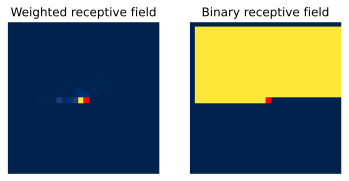

In [15]:
test_model = PixelCNN(1, 64)
inp = torch.zeros(1,1,28,28)
inp.requires_grad_()
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

For predicting a pixel, we can take almost half of the image into account. 
However, keep in mind that this is the "theoretical" receptive field and not necessarily the effective receptive field, which is usually much smaller. 
For a stronger model, we should therefore try to increase the receptive field even further.

### Training loop

Training the model is again straight forward. We use the bits per dimension metric here to stay comparable to Normalizing Flows and Variational Autoencoders.

In [16]:
def train_model(model, model_name, max_epochs=80):
    model_file = os.path.join(CHECKPOINT_PATH, model_name + ".tar")
    if os.path.isfile(model_file):
        print("Found pretrained model. Loading state dict...")
        model.load_state_dict(torch.load(model_file))
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99) # Every epoch, we multiply the LR by 0.95
        train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)

        print("Start training %s..." % model_name)

        avg_bpd = 8.0

        val_scores = []
        for epoch in range(max_epochs):
            pbar = tqdm(train_loader, leave=False)
            for imgs, _ in pbar:
                imgs = imgs.to(device)
                optimizer.zero_grad()
                bpd = model.calc_likelihood(imgs).mean()
                bpd.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                avg_bpd = 0.9 * avg_bpd + 0.1 * bpd.item()
                pbar.set_description("[Epoch %i] Bits per dimension: %5.3fbpd" % (epoch+1, avg_bpd))
            lr_scheduler.step()
            
            val_bpd = test_model(model, val_loader)
            print("[Epoch %2i] Validation bits per dimension: %5.3fbpd" % (epoch+1, val_bpd))

            if len(val_scores) == 0 or val_bpd < min(val_scores):
                print("\t   (New best performance, saving model...)")
                save_model(model, CHECKPOINT_PATH, model_name)
            val_scores.append(val_bpd)

            if (epoch+1) % 5 == 0:
                samples = model.sample(img_shape=(8,1,28,28))
                show_imgs(samples.cpu())

        # Plot a curve of the validation accuracy
        sns.set()
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation bits per dimension")
        plt.title("Validation performance of %s" % model_name)
        plt.show()
        plt.close()
    
    test_bpd = test_model(model, test_loader)
    print("Test bits per dimension: %5.3fbpd" % (test_bpd))
    
def test_model(model, data_loader):
    model.eval()
    test_bpd, counter = 0.0, 0
    for imgs, _ in tqdm(data_loader, leave=False, desc="Testing..."):
        imgs = imgs.to(device)
        with torch.no_grad():
            img_bpd = model.calc_likelihood(imgs)
            test_bpd += img_bpd.sum().item()
            counter += img_bpd.shape[0]
    test_bpd = test_bpd / counter
    return test_bpd 

def save_model(model, model_path, model_name):
    os.makedirs(model_path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_path, model_name + ".tar"))

Training the model is time consuming and we recommend using the provided pre-trained model for going through this notebook. However, feel free to play around with the hyperparameter like number of layers etc. if you want to get a feeling for those. 

When calling the training function with a pre-trained model, we automatically load it and only perform the test (recommended to use GPU, CPU takes about 1 minute):

In [17]:
model = PixelCNN(c_in=1, c_hidden=64).to(device)
train_model(model, model_name="PixelCNN_deep", max_epochs=150)

Found pretrained model. Loading state dict...


Test bits per dimension: 0.809bpd


With a test performance of 0.809bpd, the PixelCNN significantly outperforms the normalizing flows we have seen in Tutorial 9.2. 
Considering image modeling as an autoregressive problem simplifies the learning process as predicting one pixel given the ground truth of all others is much easier than predicting all pixels at once.
In addition, PixelCNN can explicitly predict the pixel values by a discrete softmax while Normalizing Flows have to learn transformations in continuous latent space.
These two aspects allow the PixelCNN to achieve a notably good performance. 

To fully compare the models, let's also measure the number of parameters of the PixelCNN:

In [18]:
num_params = sum([np.prod(param.shape) for param in model.parameters()])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 852,160


The PixelCNN has also considerably less parameters than the multi-scale normalizing flows. 
Of course, the number of parameters depend on our hyperparameter choices.
But in general, it can be said that autoregressive models require considerably less parameters than normalizing flows to reach good performance.

## Sampling

One way of qualitatively analysing generative models is by looking at the actual samples.
Let's therefore use our sampling function to generate a few digits:

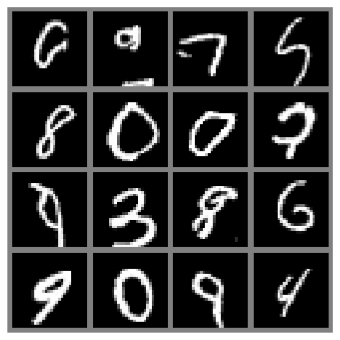

In [19]:
set_seed(1)
samples = model.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

Most of the samples can be identified as digits, and in general we achieve a better quality than we had in normalizing flows.
This goes along with the lower likelihood we achieved with autoregressive models.
Nevertheless, we also see that there is still place for improvement as a considerable amount of samples cannot be identified. 
Deeper models are expected to achieve better quality, as they can take more context into account for generating the pixels.

What happens if we actually sample a larger image than we had seen in our training dataset?

In [ ]:
set_seed(1)
samples = model.sample(img_shape=(8,1,64,64))
show_imgs(samples.cpu())

The larger images show that changing the size of the image during testing confuses the model and generates abstract figures (you can sometimes spot a digit in the upper left corner).
In addition, sampling for images of 64x64 pixels take more than a minute on a GPU. 
Clearly, autoregressive models cannot be scaled to large images without changing the sampling procedure. 
Our implementation is also not the most efficient as many computations can be stored and reused throughout the sampling process.
Nevertheless, the sampling procedure stays sequential which is inherently slower than parallel generation like done in normalizing flows.

### Autocompletion

One common application done with autoregressive models is auto-completing an image. 
As autoregressive models predict pixels one by one, we can set the first $N$ pixels to predefined values and check how the model completes the image. 
The implementation is rather simple:

In [ ]:
def autocomplete_image(img):
    img_init = img.clone()
    img_init[:,10:,:] = -1
    show_imgs([img,img_init])
    img_init = img_init.unsqueeze(dim=0).expand(12,-1,-1,-1).to(device)

    set_seed(1)
    img_generated = model.sample(img_init.shape, img_init)
    show_imgs(img_generated)

for i in range(1,4):
    img = train_set[i][0]
    autocomplete_image(img)

### Visualization of the predictive distribution (softmax)

Autoregressive models use a softmax over 256 values to predict the next pixel.
This gives the model a large flexibility as the probabilities for each pixel value can be learned independently if necessary.
However, the values are actually not independent because the values 32 and 33 are much closer than 32 and 255. 
In the following, we visualize the softmax distribution that the model predicts to gain insights how it has learned these relationships.

To do this, we first run the model on a batch of images and store the output softmax distributions:

In [ ]:
imgs,_ = next(iter(train_loader))
imgs = imgs.to(device)
with torch.no_grad():
    out = model(imgs)
    out = F.softmax(out, dim=1)
    mean_out = out.mean(dim=[0,2,3,4]).cpu().numpy()
    out = out.cpu().numpy()

Before diving into the model, let's visualize the distribution of the pixel values in the dataset:

In [ ]:
sns.set()
plot_args = {"color": to_rgb("C0")+(0.5,), "edgecolor": "C0", "linewidth": 0.5, "width": 1.0}
plt.hist(imgs.view(-1).cpu().numpy(), bins=256, density=True, **plot_args)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()

As we would expect from the seen images, the pixel value 0 (black) is the dominant value, followed by a batch of values between 250 and 255. 
Note that we use a log scale on the y-axis due to the big imbalance in the dataset.
Interestingly, the pixel values 64, 128 and 191 also stand out which is likely due to the quantization used during the creation of the dataset. 

Next, we can visualize the distribution our model predicts (in average):

In [ ]:
plt.bar(np.arange(mean_out.shape[0]), mean_out, **plot_args)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()

This distribution is very close to the actual dataset distribution.

We can also visualize the distribution for individual images to get a better intuition:

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,6))
for i in range(4):
    ax_sub = ax[i//2][i%2]
    ax_sub.bar(np.arange(out.shape[1], dtype=np.int32), out[i+4,:,0,14,14], **plot_args)
    ax_sub.set_yscale("log")
    ax_sub.set_xticks([0,64,128,192,256])
plt.show()
plt.close()

* Different distributions possible
* However, first and second image is very noisy which should not happen for natural images
* Better => discrete logistic mixtures

## Autoregressive models beyond PixelCNN

* Discrete Logistic Mixture Likelihood
* Multi-scale with short-cut connections
* Order of pixel

## Conclusion

## References
[1] van den Oord, A., et al. "Pixel Recurrent Neural Networks." arXiv preprint arXiv:1601.06759 (2016). [link](https://arxiv.org/abs/1601.06759)

[2] van den Oord, A., et al. "Conditional Image Generation with PixelCNN Decoders." In Advances in Neural Information Processing Systems 29, pp. 4790–4798 (2016). [link](http://papers.nips.cc/paper/6527-conditional-image-generation-with-pixelcnn-decoders.pdf)

[3] Salimans, Tim, et al. "PixelCNN++: Improving the PixelCNN with Discretized Logistic Mixture Likelihood and Other Modifications." arXiv preprint arXiv:1701.05517 (2017). [link](https://arxiv.org/abs/1701.05517)